# 3일 등락률 기준(Full Model)

In [ ]:
## 등락률 넣고 n_splits=5 매수, 매도 정확도 : 전체 정확도: 0.8277, maintain 정확도 : 0.9271, buy 정확도: 0.3704, sell 정확도:0.4737
#ks, vif 변수 넣고 돌렸지만 최악

In [24]:
import warnings
warnings.filterwarnings( 'ignore' )

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import TimeSeriesSplit
import xgboost
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import optuna
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
if os.name != 'posix':
    plt.rc("font", family="Malgun Gothic")

In [26]:
sk_label=pd.read_csv('C:/Users/fiona/Desktop/SK_label.csv', encoding='UTF-8')

In [27]:
sk=sk_label.drop(['year','month','day','day1_label','day3_label','대비','코스피대비','3일 등락률'],axis=1)
sk.shape

(1429, 39)

In [28]:
sk1=sk

In [29]:
label=pd.DataFrame(sk_label['3일 등락률'])

In [30]:
sk2=sk1.shift(1) # 한 행씩 데이터 아래로 내리기
df=pd.concat([sk2,label],axis=1)
df=df.drop(0,axis=0)
df=df.reset_index(drop=True)

In [31]:
x=df.drop(['날짜','3일 등락률'],axis=1)
y=df['3일 등락률']

In [32]:
tscv=TimeSeriesSplit(n_splits=5)

for i, (train_index, test_index) in enumerate(tscv.split(x)):
    x_train, y_train=x.iloc[train_index],y.iloc[train_index]
    x_test, y_test=x.iloc[test_index],y.iloc[test_index]
    
    scaler=MinMaxScaler()
    x_train=scaler.fit_transform(x_train)
    x_test=scaler.fit_transform(x_test)

    xgb_model = xgboost.XGBRegressor().fit(x_train, y_train)

    y_pred = xgb_model.predict(x_test)
    print(f"Fold {i+1} - MSE: {mean_squared_error(y_test, y_pred)}")
    print(f"Fold {i+1} - RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
    print()

Fold 1 - MSE: 13.94945215119622
Fold 1 - RMSE: 3.734896538218458

Fold 2 - MSE: 15.3925198609897
Fold 2 - RMSE: 3.923330200351444

Fold 3 - MSE: 18.14932833423261
Fold 3 - RMSE: 4.260202851300934

Fold 4 - MSE: 18.278869092878477
Fold 4 - RMSE: 4.275379409231241

Fold 5 - MSE: 13.069030762553616
Fold 5 - RMSE: 3.615111445384999



In [33]:
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }
    model = xgboost.XGBRegressor(**param)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    return mean_squared_error(y_test, y_pred)

In [34]:
study = optuna.create_study(direction='minimize', study_name='regression')
study.optimize(objective, n_trials=100)

[I 2023-05-08 19:30:57,068] A new study created in memory with name: regression
[I 2023-05-08 19:31:00,456] Trial 0 finished with value: 12.497243076697945 and parameters: {'max_depth': 9, 'learning_rate': 0.18271653426386147, 'n_estimators': 981, 'min_child_weight': 2, 'gamma': 0.4550843576875749, 'subsample': 0.9194162429445708, 'colsample_bytree': 0.059086563216143764, 'reg_alpha': 0.4472663743383783, 'reg_lambda': 0.6791665681006536, 'random_state': 316}. Best is trial 0 with value: 12.497243076697945.
[I 2023-05-08 19:31:01,333] Trial 1 finished with value: 1.4428366048777918e+23 and parameters: {'max_depth': 5, 'learning_rate': 0.6783835921446548, 'n_estimators': 450, 'min_child_weight': 2, 'gamma': 0.23565785519057708, 'subsample': 0.06788076129688825, 'colsample_bytree': 0.43673601559783615, 'reg_alpha': 0.6675836897038351, 'reg_lambda': 0.358680469504834, 'random_state': 80}. Best is trial 0 with value: 12.497243076697945.
[I 2023-05-08 19:31:01,662] Trial 2 finished with valu

In [35]:
print(study.best_trial)
print(study.best_params)

FrozenTrial(number=91, state=TrialState.COMPLETE, values=[8.438886773302155], datetime_start=datetime.datetime(2023, 5, 8, 19, 34, 17, 637615), datetime_complete=datetime.datetime(2023, 5, 8, 19, 34, 18, 258371), params={'max_depth': 3, 'learning_rate': 0.011235604360026557, 'n_estimators': 174, 'min_child_weight': 5, 'gamma': 0.861554821374329, 'subsample': 0.6845228907060142, 'colsample_bytree': 0.4770654787340878, 'reg_alpha': 0.9772972960788213, 'reg_lambda': 0.8155223011541921, 'random_state': 1}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=10, log=False, low=1, step=1), 'learning_rate': FloatDistribution(high=1.0, log=False, low=0.01, step=None), 'n_estimators': IntDistribution(high=1000, log=False, low=50, step=1), 'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1), 'gamma': FloatDistribution(high=1.0, log=False, low=0.01, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.01, ste

In [36]:
for i, (train_index, test_index) in enumerate(tscv.split(x)):
    x_train, y_train=x.iloc[train_index],y.iloc[train_index]
    x_test, y_test=x.iloc[test_index],y.iloc[test_index]
    
    scaler=MinMaxScaler()
    x_train=scaler.fit_transform(x_train)
    x_test=scaler.fit_transform(x_test)

    xgb_model = xgboost.XGBRegressor(**study.best_params).fit(x_train, y_train)

    y_pred = xgb_model.predict(x_test)
    print(f"Fold {i+1} - MSE: {mean_squared_error(y_test, y_pred)}")
    print(f"Fold {i+1} - RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
    print()

Fold 1 - MSE: 12.44502947582739
Fold 1 - RMSE: 3.527751334182639

Fold 2 - MSE: 13.868249301129168
Fold 2 - RMSE: 3.7240098417068084

Fold 3 - MSE: 12.246218451859686
Fold 3 - RMSE: 3.49945973713939

Fold 4 - MSE: 12.792788056814494
Fold 4 - RMSE: 3.576700722287859

Fold 5 - MSE: 8.438886773302155
Fold 5 - RMSE: 2.9049762087325526



In [37]:
y_test1=pd.DataFrame(y_test)
y_test1=y_test1.reset_index(drop=True)

In [38]:
y_test1['encoding'] = y_test1['3일 등락률'].apply(lambda x: 1 if abs(x) < 5 else 0 if x >= 5 else 2)

In [39]:
y_pred1=pd.DataFrame(y_pred)
y_pred1.columns=['3일 등락률']
y_pred1.head(5)

,3일 등락률
0,-2.321523
1,0.376451
2,3.007470
3,-0.083838
4,2.051495


In [40]:
y_pred1['encoding'] = y_pred1['3일 등락률'].apply(lambda x: 1 if abs(x) < 5 else 0 if x >= 5 else 2)

In [41]:
accuracy=accuracy_score(y_test1['encoding'],y_pred1['encoding'])
maintain_correct = 0
buy_correct = 0
sell_correct = 0
for i in range(len(y_test1)):
    if y_test1.iloc[i]['encoding'] == 1 and y_pred1.iloc[i]['encoding'] == 1:
        maintain_correct += 1
    if y_test1.iloc[i]['encoding'] == 0 and y_pred1.iloc[i]['encoding'] == 0:
        buy_correct += 1
    if y_test1.iloc[i]['encoding'] == 2 and y_pred1.iloc[i]['encoding'] == 2:
        sell_correct += 1

maintain_acc=maintain_correct/len(y_test1[y_test1['encoding'] == 1])
buy_acc = buy_correct / len(y_test1[y_test1['encoding'] == 0])
sell_acc = sell_correct / len(y_test1[y_test1['encoding'] == 2])

In [42]:
print(f'전체 정확도: {accuracy:.4f}')
print(f'maintain 정확도 : {maintain_acc:.4f}')
print(f'buy 정확도: {buy_acc:.4f}')
print(f'sell 정확도:{sell_acc:.4f}')

전체 정확도: 0.8193
maintain 정확도 : 0.9948
buy 정확도: 0.1111
sell 정확도:0.0526


In [43]:
date=pd.DataFrame()
date['날짜']=sk_label['날짜'].drop([0],axis=0)
date=date.iloc[1190:,]
date=date.reset_index(drop=True)
test=pd.concat([y_test1,date],axis=1)
pred=pd.concat([y_pred1,date],axis=1)

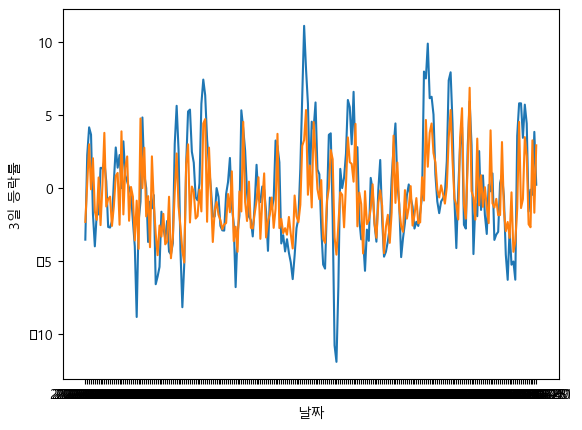

In [44]:
sns.lineplot(y=test.iloc[:,0],x=test['날짜'],data=test)
sns.lineplot(y=pred.iloc[:,0],x=pred['날짜'],data=pred)